In [1]:
%reset -sf

import sys
sys.path.insert(0, '../qe')
import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

import os
import glob
import shutil

from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
print(tf.__version__)


# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        
        # Instead of enabling memory growth, set a memory limit
        memory_limit = 16_384  # Set the memory limit in MB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
        )
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


2.13.0
2 Physical GPUs, 1 Logical GPU


In [2]:
SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor()
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 76



['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [3]:
## Global variables

GEV = 1e3

# cut_pre_pt_lead = data.LeadLep["pt"] > 35 * GEV
# cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
# cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
# cut_pre_pt_miss = data.MET["pt"] > 20 * GEV

cut_pre_pt_lead = data.LeadLep["pt"] > -999 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > -999 * GEV
cut_pre_dilep_m = data.diLep["m"] > -999 * GEV
cut_pre_pt_miss = data.MET["pt"] > -999 * GEV

PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

BATCH_SIZE = 4096
EPOCHS = 1024
LEARNING_RATE = 5e-4

w_lead shape: (2928862, 9)
                  E            px            py            pz             m  \
count  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06   
mean   2.283278e+05 -1.788823e+01  1.700620e+01  2.688194e+02  7.062466e+04   
std    2.440128e+05  3.510948e+04  3.504798e+04  3.222953e+05  1.877761e+04   
min    1.596886e+04 -1.474598e+06 -7.555793e+05 -4.386726e+06  2.000148e+03   
25%    9.528028e+04 -1.782399e+04 -1.778516e+04 -1.062248e+05  7.283715e+04   
50%    1.397490e+05 -7.059609e+00  1.686714e+00  2.295375e+02  7.960655e+04   
75%    2.580234e+05  1.782398e+04  1.782713e+04  1.065598e+05  8.073579e+04   
max    4.387744e+06  8.572401e+05  8.429514e+05  4.286328e+06  1.160078e+05   

                 pt           eta           phi             y  
count  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06  
mean   3.827814e+04  3.248780e-03  8.722714e-05  2.046535e-03  
std    3.155663e+04  2.378962e+00  1.814154e+00  1.486413e+00  
min  

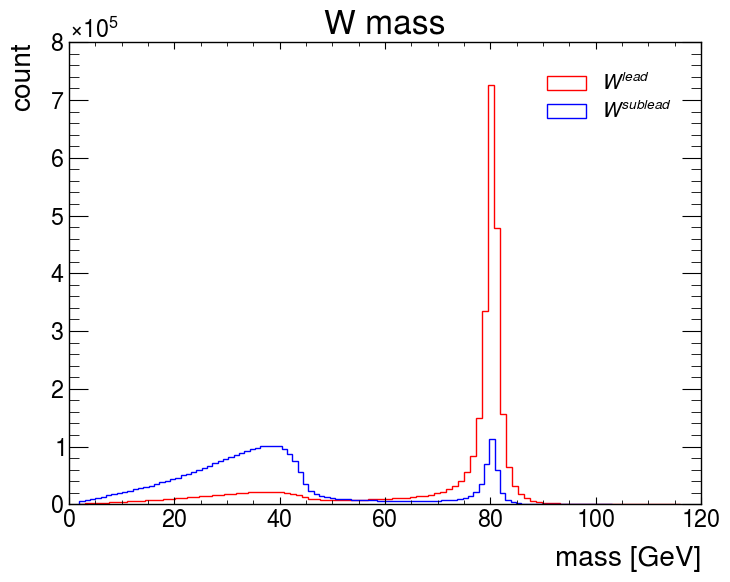

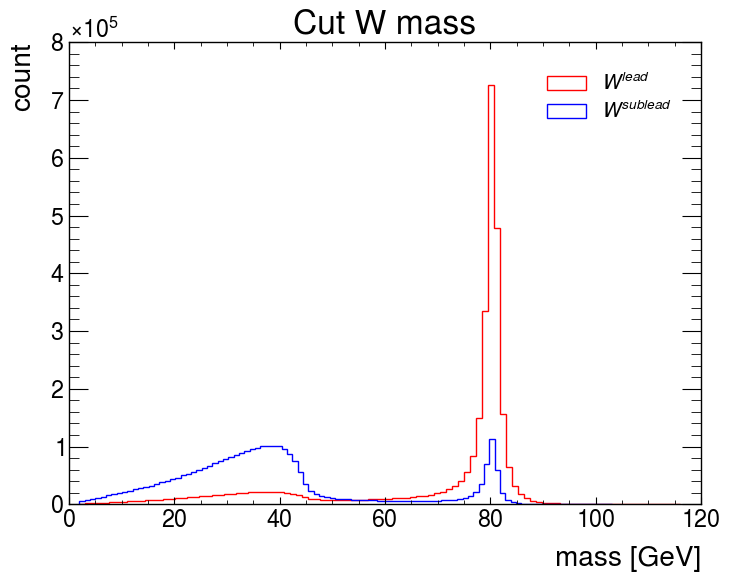

int_kin shape: (2928862, 7)
            E         px         py          pz         pt       eta       phi
0   58.711652  38.546070  31.123209   20.959885  49.542443  0.000411  0.000679
1  358.513500  68.210398 -22.334633  348.815500  71.773911  0.002285 -0.000316
2   92.610430  10.685407 -46.849344   70.222906  48.052460  0.001173 -0.001347
                  E            px            py            pz            pt  \
count  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06   
mean   1.404083e+02 -2.686588e-02 -1.476071e-02  1.933113e-01  2.761544e+01   
std    1.624061e+02  2.429328e+01  2.430197e+01  2.074607e+02  2.044841e+01   
min    5.416974e+00 -6.911612e+02 -8.249657e+02 -3.927153e+03  1.018569e-02   
25%    5.182750e+01 -1.384852e+01 -1.383030e+01 -6.225817e+01  1.543063e+01   
50%    8.548199e+01 -1.345119e-02 -2.286590e-03  1.198130e-01  2.374860e+01   
75%    1.579316e+02  1.379049e+01  1.381654e+01  6.263841e+01  3.371116e+01   
max    3.927979e+03  4.7

In [4]:
## Interesting variables

# Critria for leading and subleading lepton
lead_p = data.LeadLep["m"] == data.LepP["m"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

# (sub)lead W
w_lead = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0).sort_index()
w_sublead = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0).sort_index()
print("w_lead shape:", w_lead.shape)
print(w_lead.describe())

# Check (sub)lead W
plt.hist(w_lead["m"] / GEV, bins=100, color="r", histtype="step", label=r"$W^{lead}$")
plt.hist(
    w_sublead["m"] / GEV, bins=100, color="b", histtype="step", label=r"$W^{sublead}$"
)
plt.title("W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()
# Check (sub)lead W
plt.hist(
    w_lead["m"][PRE_CUT] / GEV,
    bins=100,
    color="r",
    histtype="step",
    label=r"$W^{lead}$",
)
plt.hist(
    w_sublead["m"][PRE_CUT] / GEV,
    bins=100,
    color="b",
    histtype="step",
    label=r"$W^{sublead}$",
)
plt.title("Cut W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()

# Kinematics of interesting variables (target for training)
int_kin = w_sublead[["E", "px", "py", "pz", "pt", "eta", "phi"]][PRE_CUT] / GEV
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print(int_kin.describe())
# int_kin = int_kin.to_numpy() # convert to numpy array
# STDSCALAR_INT = StandardScaler()
# int_kin = STDSCALAR_INT.fit_transform(int_kin)
ROBUST_INT = RobustScaler()
int_kin = ROBUST_INT.fit_transform(int_kin)
# MINMAX_INT = MinMaxScaler()
# int_kin = MINMAX_INT.fit_transform(int_kin)
print(type(int_kin))

In [5]:
## Observing variables

met = data.MET[["px", "py"]]
lead_lep = data.LeadLep[["E", "px", "py", "pz", "pt", "eta", "phi"]]
sublead_lep = data.SubLep[["E", "px", "py", "pz", "pt", "eta", "phi"]]

# Kinematics of observing variables (inputs for training)
obs_kin = pd.concat([lead_lep, sublead_lep, met], axis=1)[PRE_CUT] / GEV
print("int_kin shape:", obs_kin.shape)
print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
ROBUST_OBS = RobustScaler()
obs_kin = ROBUST_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (2928862, 16)
                  E            px            py            pz            pt  \
count  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06   
mean   1.197425e+02 -3.234511e-02  8.371231e-03  1.433632e-01  3.977981e+01   
std    1.498027e+02  3.141150e+01  3.138210e+01  1.865678e+02  1.972528e+01   
min    9.996190e-04 -8.960873e+02 -5.162718e+02 -3.097812e+03  3.322850e-04   
25%    4.268904e+01 -2.281384e+01 -2.279909e+01 -5.112502e+01  2.793390e+01   
50%    6.802523e+01 -4.159428e-02  3.938607e-02  5.318093e-02  3.595172e+01   
75%    1.321814e+02  2.278163e+01  2.279003e+01  5.142163e+01  4.599537e+01   
max    3.199309e+03  8.355693e+02  5.822423e+02  3.199011e+03  8.970521e+02   

                eta           phi             E            px            py  \
count  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06   
mean   1.854006e-06  1.128448e-06  6.328954e+01 -1.347791e-02 -9.528050e-03   
std    1.585678e-03  1

In [6]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.6,
    test_size=0.4,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

X (Interest)
Training data shape: (1757317, 16);
Validing data shape: (585772, 16);
Testing data shape: (585773, 16).
Y (Observed)
Training data shape: (1757317, 7);
Validing data shape: (585772, 7);
Testing data shape: (585773, 7).


In [7]:
# Define a new activation function


def custom_activation(x):
    return (0.73 - (-0.27)) * (tf.tanh(x) + 1) / 2 + (-0.27)


# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=2048, activation="elu")(x)
    x = tf.keras.layers.Dense(units=2048, activation="elu")(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    x = tf.keras.layers.Dense(units=256, activation="elu")(x)
    x = tf.keras.layers.Dense(units=256, activation="elu")(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)
    x = tf.keras.layers.Dense(units=64, activation="elu")(x)

    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="linear")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="mse",
    )

    return model

In [8]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 2048)              34816     
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 256)               65792 

In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=20,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.01)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    use_multiprocessing=True,
    callbacks=[stop_early],
    # callbacks=[stop_early,lr_scheduler],
)

Epoch 1/1024
430/430 - 13s - loss: 0.4465 - val_loss: 0.4276 - 13s/epoch - 31ms/step
Epoch 2/1024
430/430 - 7s - loss: 0.4180 - val_loss: 0.4141 - 7s/epoch - 15ms/step
Epoch 3/1024
430/430 - 7s - loss: 0.4128 - val_loss: 0.4195 - 7s/epoch - 15ms/step
Epoch 4/1024
430/430 - 6s - loss: 0.4094 - val_loss: 0.4068 - 6s/epoch - 15ms/step
Epoch 5/1024
430/430 - 6s - loss: 0.4059 - val_loss: 0.4072 - 6s/epoch - 14ms/step
Epoch 6/1024
430/430 - 6s - loss: 0.4022 - val_loss: 0.4002 - 6s/epoch - 15ms/step
Epoch 7/1024
430/430 - 7s - loss: 0.4000 - val_loss: 0.3955 - 7s/epoch - 16ms/step
Epoch 8/1024
430/430 - 6s - loss: 0.3981 - val_loss: 0.4066 - 6s/epoch - 15ms/step
Epoch 9/1024
430/430 - 7s - loss: 0.3969 - val_loss: 0.3968 - 7s/epoch - 15ms/step
Epoch 10/1024
430/430 - 7s - loss: 0.3953 - val_loss: 0.3925 - 7s/epoch - 16ms/step
Epoch 11/1024
430/430 - 6s - loss: 0.3938 - val_loss: 0.3965 - 6s/epoch - 15ms/step
Epoch 12/1024
430/430 - 7s - loss: 0.3944 - val_loss: 0.3919 - 7s/epoch - 15ms/step

In [10]:
# Make a directory
dir_name = "./w_sublead_result/"
name = "dnn_w_sublead_full_scaled"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
else:
    os.makedirs(dir_name)

# save model
model.save(dir_name + name + ".h5", save_format="h5", overwrite=True)

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18306/18306 [==============================] - 70s 4ms/step


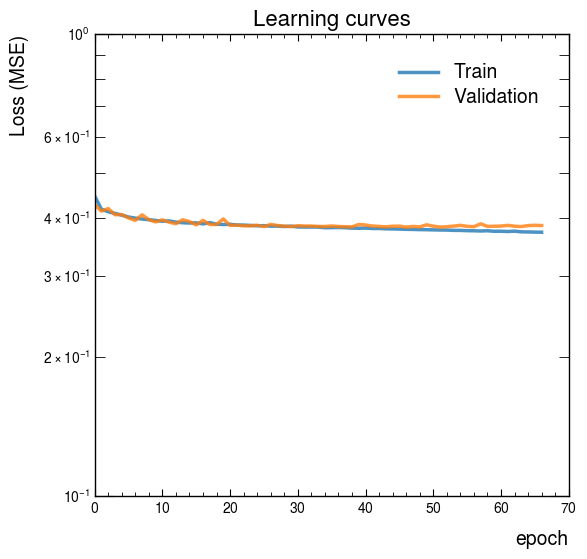

In [11]:
plot.plot_loss_history(history, logx=False, logy=True)

In [12]:
sig_truth_inv = ROBUST_INT.inverse_transform(sig_truth)
sig_pred_inv = ROBUST_INT.inverse_transform(sig_pred)

In [13]:
# Make a directory
dir_name = "./w_sublead_result/"
name = "dnn_w_sublead_full"

# save predicted results
np.savez_compressed(
    os.path.join(dir_name, name + "_data.npz"), pred_y=sig_pred_inv, test_y=sig_truth_inv
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

Truth mean: 140.341, std: 162.053, min: 7.208, max: 3217.117


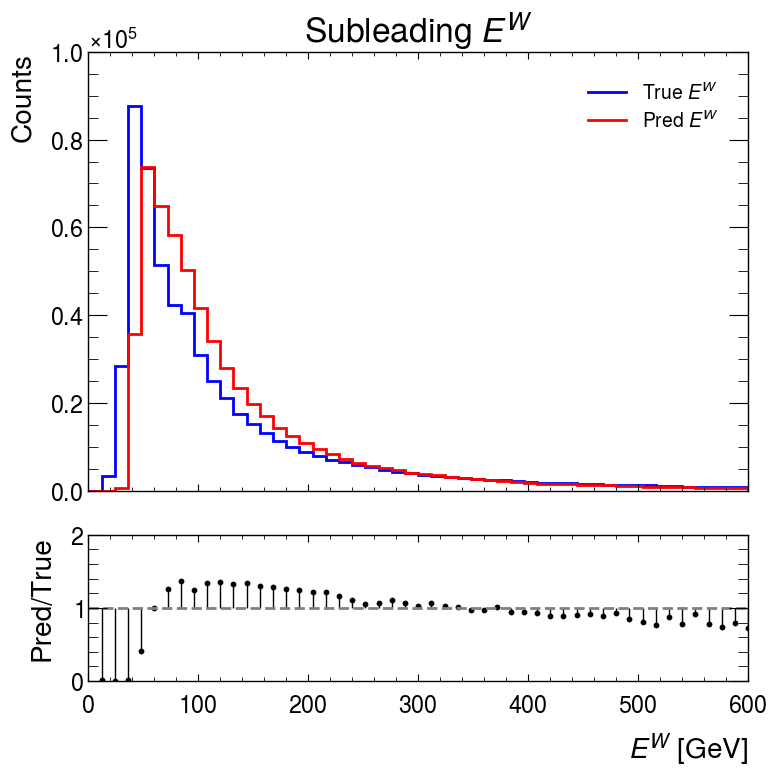

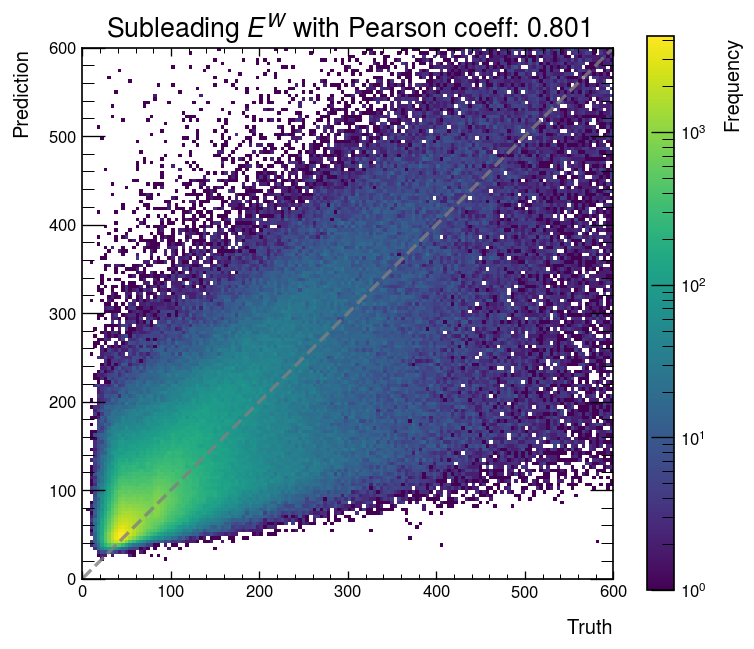

In [14]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

range = [0, 600]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$E^{W}$",
    title="Subleading $E^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0])):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"Subleading $E^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,0], sig_pred_inv[:,0])[0]:.3f}",
    range=range,
)

Truth mean: -0.043, std: 24.389, min: -691.161, max: 473.069


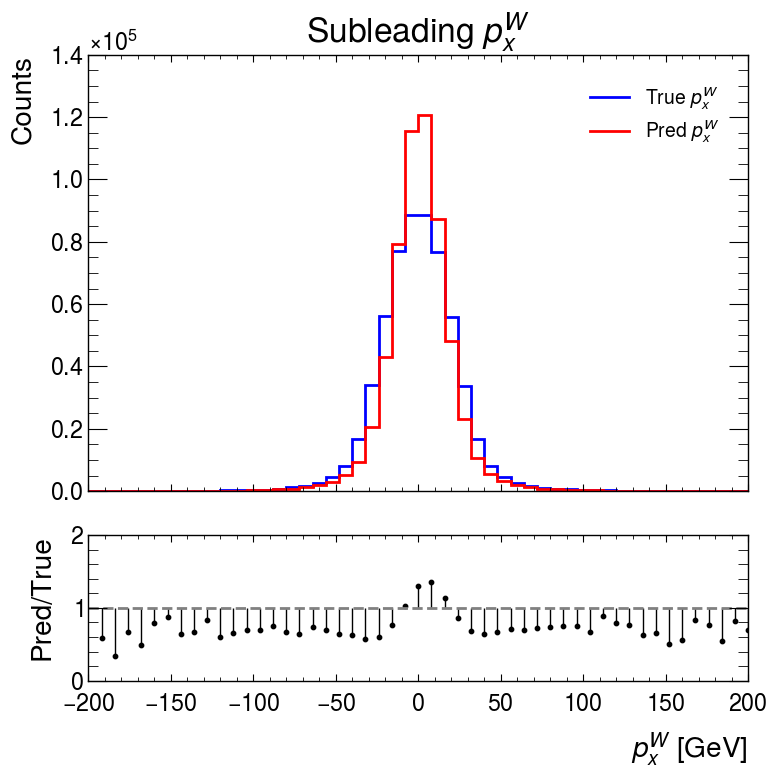

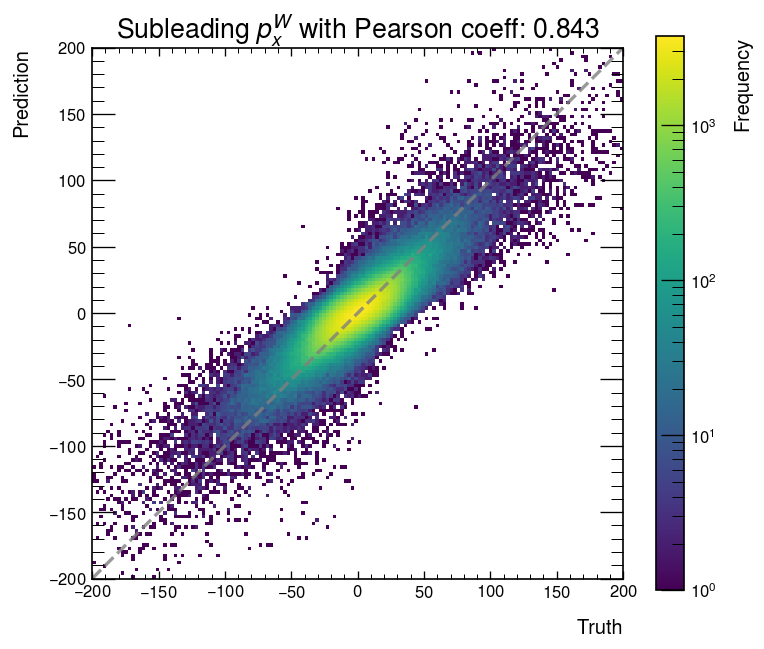

In [15]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{x}^{W}$",
    title="Subleading $p_{x}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1])):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"Subleading $p_{x}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,1], sig_pred_inv[:,1])[0]:.3f}",
    range=range,
)

Truth mean: 0.034, std: 24.321, min: -515.411, max: 580.447


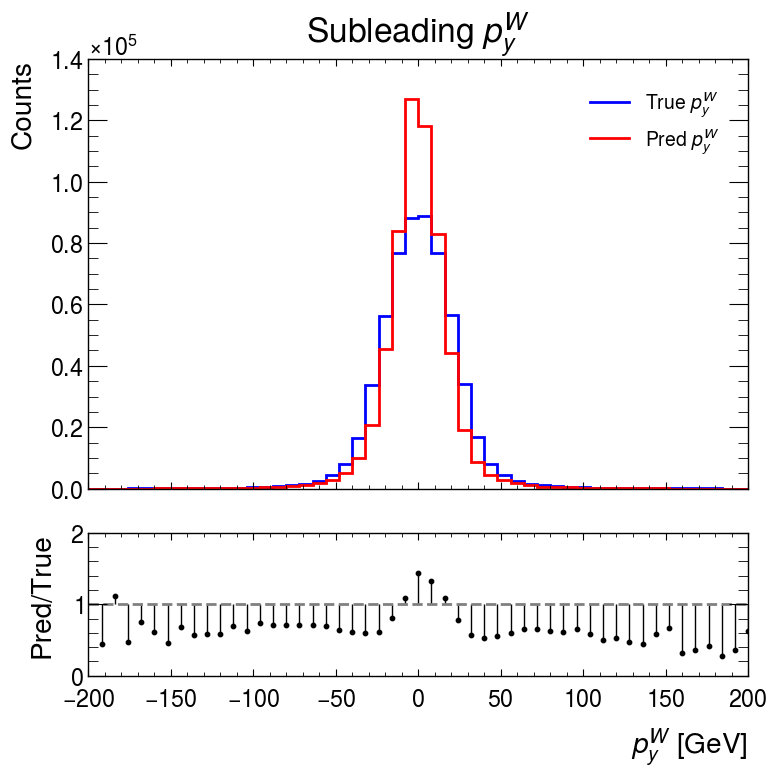

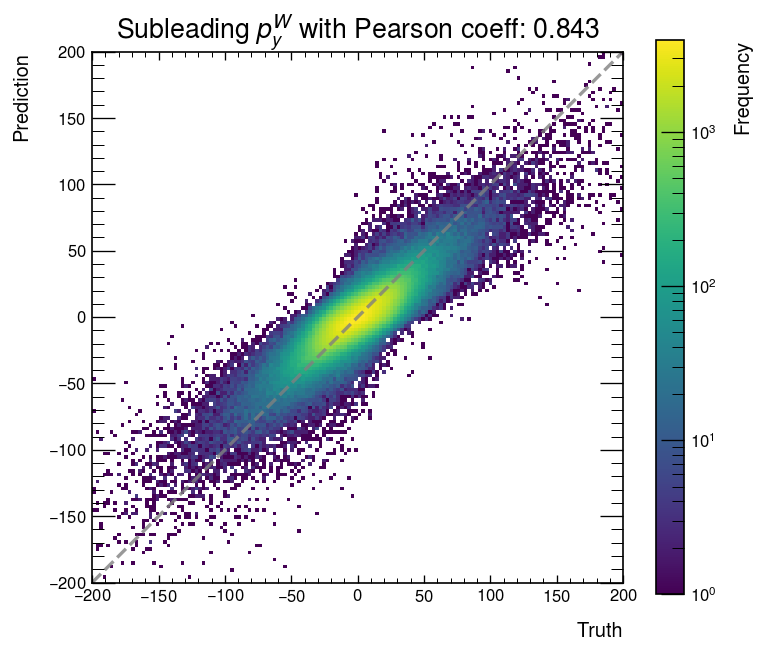

In [16]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{y}^{W}$",
    title="Subleading $p_{y}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2])):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"Subleading $p_{y}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,2], sig_pred_inv[:,2])[0]:.3f}",
    range=range,
)

Truth mean: 0.244, std: 207.122, min: -3215.880, max: 2989.094


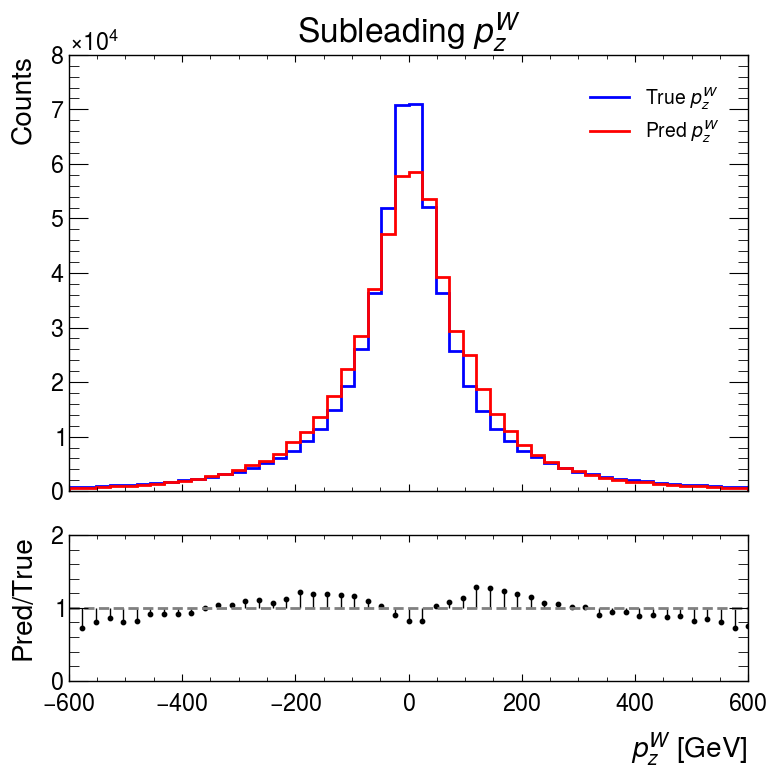

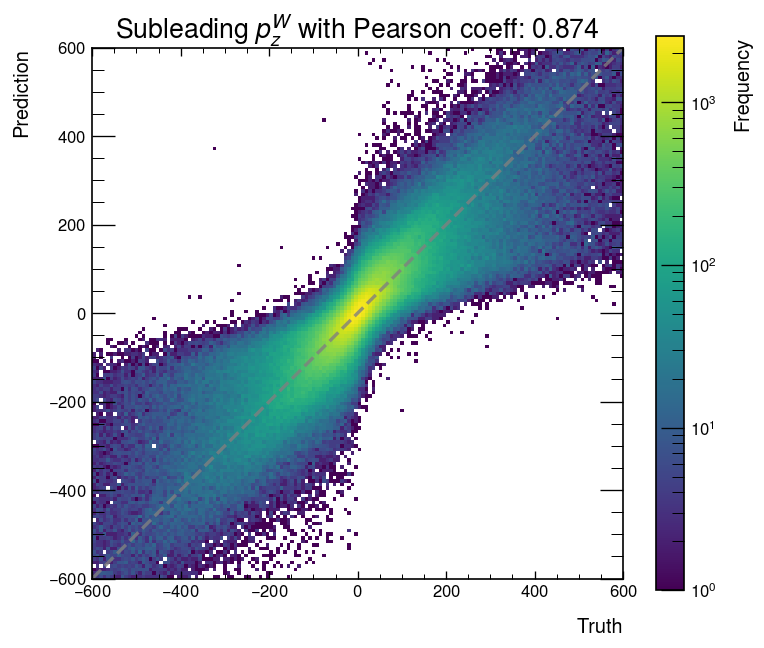

In [17]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

range = [-600, 600]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$p_{z}^{W}$",
    title="Subleading $p_{z}^{W}$",
    # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3])):.3f}",
    range=range,
    unit="[GeV]",
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"Subleading $p_{z}^{W}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,3], sig_pred_inv[:,3])[0]:.3f}",
    range=range,
)

In [18]:
# range = [0, 100]

# plot.hist(
#     data=[sig_truth_inv[:,4], sig_pred_inv[:,4]],
#     label=r"$m^{W}$",
#     title="Subleading $m^{W}$",
#     # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4])):.3f}",
#     range=range,
#     unit = "[GeV]"
# )

# plot.plot_2d_histogram(
#     sig_truth_inv[:,4],
#     sig_pred_inv[:,4],
#     r"Subleading $m^{W}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth_inv[:,4], sig_pred_inv[:,4])[0]:.3f}",
#     range=range,
# )